# Assignment 7: t-SNE for Dimensionality Reduction and Visualization
Lauren Enriquez

## 1. PCA vs t-SNE

Previously we looked at PCA as a method for dimensionality reduction by transforming data using a basis of the direction of maximum variation. Here we'll compare the two methods using the out of the box methods from scikit-learn.

Clarification: Normalize X to be between 0 and 1 such that it spans the whole range [0, 1] - the minimum should be 0! It might not work if you just divide by the max.

Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Some Setup

In [3]:
from sklearn.datasets import load_digits
from sklearn.utils import shuffle
digits = load_digits()

In [4]:
X = digits.data
y = digits.target

# Create a variable called "image" that uses the images method that loads the same 
#feature values as "X" and then visualizes the actual handwritten character
image = digits.images

In [5]:
# Scale X to be between 0 and 1 (avoid magic numbers - define global constants and use them!)

# TODO: Scale X to 0 and 1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [6]:
# Shuffle data (I included "image" in the shuffle to keep the data organized)
X, y, image = shuffle(X, y,image)

In [7]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1797, 64)
y shape: (1797,)


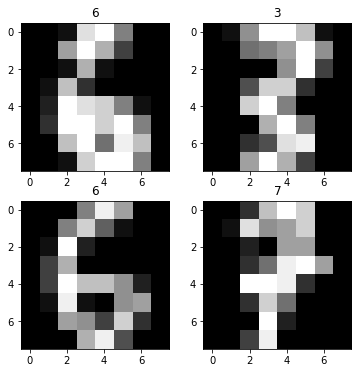

In [8]:
# Look at the data we're working with

plt.figure(figsize=(6,6))

for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(y[i])    
    # TODO: Plot X[i]
    # I used the variable "image" which is the image representation of X[i]
    plt.imshow(image[i],cmap=plt.cm.gray, interpolation='nearest')

plt.show()

As you can see from the above code, our input data has 64 features, each resembling a pixel in each image. We want to reduce the dimensionality of our input using both PCA and t-SNE to visualize all the data points on one chart.

### 1.a) PCA

In [9]:
# Carry out PCA on X

pca = PCA(n_components=2)
# TODO: Run PCA on X to get the first 2 principal components
X_pca = pca.fit_transform(X)

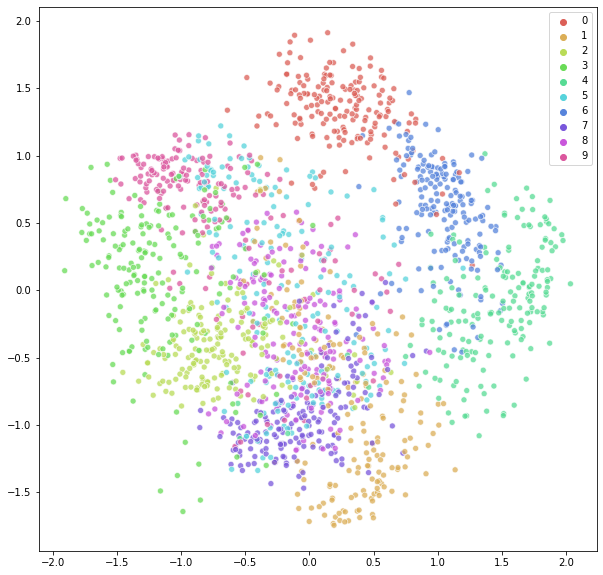

In [10]:
# Visualize X_pca

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_pca[:,0], y=X_pca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75)

plt.show()

### 1.b) t-SNE

In [11]:
# Carry out t-SNE on X
tsne = TSNE(n_components=2)
# TODO: Run t-SNE on X
X_tsne = tsne.fit_transform(X)

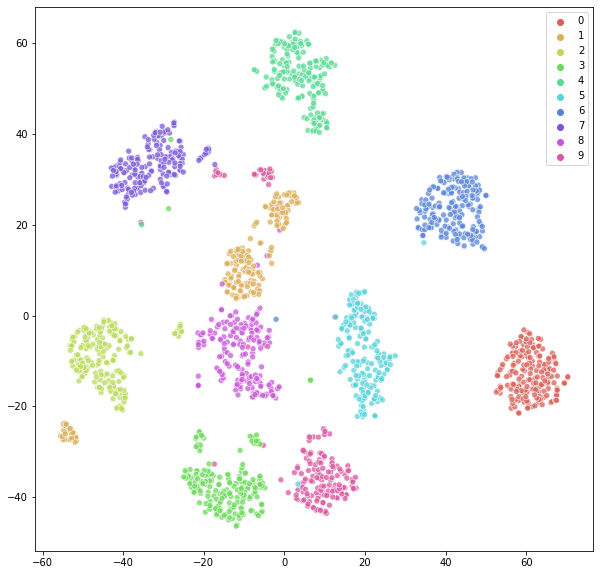

In [12]:
# Visualize X_tsne
plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

## 2. Implementing t-SNE

In this exercise, we follow the implementation of t-SNE directly from the 2008 paper by Maaten and Hinton. It builds upon SNE (Stochastic Neighbor Embedding) and "reduces the tendency to crowd points together in the center
of the map."

#### Intro/Definitions

The goal of t-SNE is to define a location $y_i$ in low-dimension space for high-dimensional points $x_i$. Each point $x_i$ has a probability distribution associated with it of picking another point $x_j$ as its neighbor, defined as $p_{j|i}$ in equation 1 of the paper. $P_i$ is defined as the distribution of other high-dimensional points given $x_i$. Analagously for the low-dimensional points (which we have yet to find), $Q_i$ is defined as the distribution of other low-dimensional points given $y_i$

#### Cost function description

In SNE, the cost function that we're trying to minimize is the "difference" between $P_i$ and $Q_i$ (we want them to be similar). How do we measure difference for probability distributions? The Kullback-Leibler divergence is a measure of dissimilarity between two distributions $P$ and $Q$, defined as $$ \sum_i \left( P(i) \cdot log \frac{P(i)}{Q(i)} \right) $$ for all values $i$ that $P$ and $Q$ take on. You can see how if $P = Q$ for all $i$ (same distribution), the log term will always be $\log 1 = 0$, and so the KLD will be 0 (no dissimilarity). 

As they state in the paper, "In particular, there
is a large cost for using widely separated map points to represent nearby datapoints (i.e., for using a small $q_{j|i}$ to model a large $p_{j|i}$), but there is only a small cost for using nearby map points to
represent widely separated datapoints." You can see that is true - if for some pair of points the $q$ is big and the $p$ is not, the term $$p\cdot log \frac{p}{q}$$ will be small! That will mean that it can mistraslate to low dimension sneakily without seeming like the cost is going up. That is one of the motivations behind t-SNE over SNE.

In [13]:
def Hbeta(D=np.array([]), beta=1.0):
    """
    Compute the perplexity and the P-row for a specific value of the
    precision of a Gaussian distribution.
    
    As we see in the paper, it can be interpreted as a smooth measure of the 
    effective number of neighbors (non-integer).
    """
    # TASK: Follow equation 1 and compute the numerators of all the p_j|i.
    
    # TODO: Assuming beta represents whatever variance division 
    # term the algorithm decides, multiply and exponentiate to get P's 
    # numerator. Check your signs!
    # Hint: No subtraction is necessary because x_i's position is 
    # treated as 0, since we are looking at the Gaussian around x_i.
    
    P = np.exp(-D.copy()*beta)
        
    # computing perplexity in a vectorized + fast manner
    H = np.log(np.sum(P)) + beta * np.sum(D * P) / np.sum(P)
    
    # TODO: Normalize P to apply conditioning (1 line)
    P = P/(np.sum(P))
        
    return H, P

Now we will use the perplexity and conditional probability distributions we have computed, and brute force search for conditional Gaussians that have the same perplexity! (i.e. the $P_i$'s, or the rows of the $n$ by $n$ $P$ matrix)

A way to intuitively think about this is that we should expect any two points to estimate that the "soft" number of neighbors is the same, if they're in the same neighborhood.

In [14]:
def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

    # NOTE: the P you compute should be of this shape. 
    # Make sure you understand why!
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    
    # NOTE: desired perplexity
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        
        # TODO: Utilize your newly written function to get perplexity and Pvals 
        # (1 line)
        H, thisP = Hbeta(Di, beta[i])

        # TODO: Evaluate whether the perplexity is within tolerance (1 line)
        
        Hdiff =  H - logU
        # Hint - don't apply absolute value yet - we need to know the sign
        # of this value for binary search! You can apply abs in the loop cond.

        tries = 0
        
        # TODO:
        # Write a loop condition that continues if we're both below the max
        # number of tries (50), and the absolute difference is greater than 
        # the tolerance.

        while np.abs(Hdiff) > tol and tries < 50:

            # TASK: If not, increase or decrease precision
            # What follows here is a version of the standard binary search checks.
            # The idea is that if we're too high (Hdiff positive), we can set the 
            # new min to be our current beta, and move our beta towards the max.
            # If the max is currently infinity, we should just double beta.
            # If the max is an actual number, set beta to be the avg of it and max.

            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    # adjust the beta
                    # TODO: 
                    beta[i] = beta[i] * 2
                else:
                    # adjust the beta
                    # TODO: 
                    beta[i] = (beta[i] + betamax) / 2
            else:
                # Opposite of above (if Hdiff is negative)
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    # TODO: 
                    beta[i] = beta[i] / 2
                else:
                    # TODO: 
                    beta[i] = (beta[i] + betamin) / 2

            # TODO: Recompute the values again using your function and the new betas
            H, thisP = Hbeta(Di, beta[i])
            
            # TODO: Recompute Hdiff
            # (same as "Evaluate whether the perplexity is within tolerance")
            Hdiff = H - logU
            
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

In [15]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

Now, we will use the Student t-distribution with one degree of freedom to compute Q, the matrix of joint probabiltiies in low dimensions (see equation 4 of the paper).

By the definition of norm squared (as we have discussed in previous assignments, the numerator can be expanded out as $$(1 + y_i^{T} y_i - 2y_i^T y_j + y_j^T y_j)^{-1}$$

In [16]:
def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    max_iter = 400
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4 # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # TASK: Compute pairwise affinities (Q)
        
        # SUBTASK: compute the numerator `num`
        
        # TODO: compute the first terms (all of the y_i's dotted with themselves)
        
        first_term = np.sum(np.square(Y),1)
        # HINT: first use np.square to square everything. Think about which way
        # a "y_i" goes - is it a row or a column?
        
        # TODO: Compute the middle term (the negative -2 one)
        # to do so, compute the *outer product* of Y with itself (use np.dot)
        
        middle_term = -2 * np.dot(Y, Y.T)
        # HINT: Why do we use the outer product here? What's the shape of middle_term?
        
        # apply the plus 1 and inverse on your previous value:
        norm_sq = np.add(np.add(middle_term, first_term).T, first_term)
        num = 1. / (1. + norm_sq)
        
        # END OF SUBTASK
        
        # TODO: set the diagonal of numerator to 0, and normalize it to get Q
        # (2 lines)
        num[range(n), range(n)] = 0
        Q = num / np.sum(num)
        
        # END OF TASK
        
        # this makes Q nonzero/non-negative, because floats are terrible
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 10 == 0:
            # TODO: Implement KL Divergence cost function on P and Q

            C = np.sum(P * np.log(P/Q))
            # HINT: make sure you wrap it with an np.sum so it's a scalar

            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop exaggerating about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 1797...
Computing P-values for point 500 of 1797...
Computing P-values for point 1000 of 1797...
Computing P-values for point 1500 of 1797...
Mean value of sigma: 0.736803
Iteration 10: error is 20.192386
Iteration 20: error is 16.561583
Iteration 30: error is 14.248431
Iteration 40: error is 13.563248
Iteration 50: error is 13.370711
Iteration 60: error is 13.257968
Iteration 70: error is 13.180218
Iteration 80: error is 13.117753
Iteration 90: error is 13.069211
Iteration 100: error is 13.037958
Iteration 110: error is 1.571254
Iteration 120: error is 1.400265
Iteration 130: error is 1.276681
Iteration 140: error is 1.178217
Iteration 150: error is 1.098256
Iteration 160: error is 1.034944
Iteration 170: error is 0.985329
Iteration 180: error is 0.945905
Iteration 190: error is 0.913898
Iteration 200: error is 0.887657
Iteration 210: error is 0.865821
Iteration 220: error is 0.847373

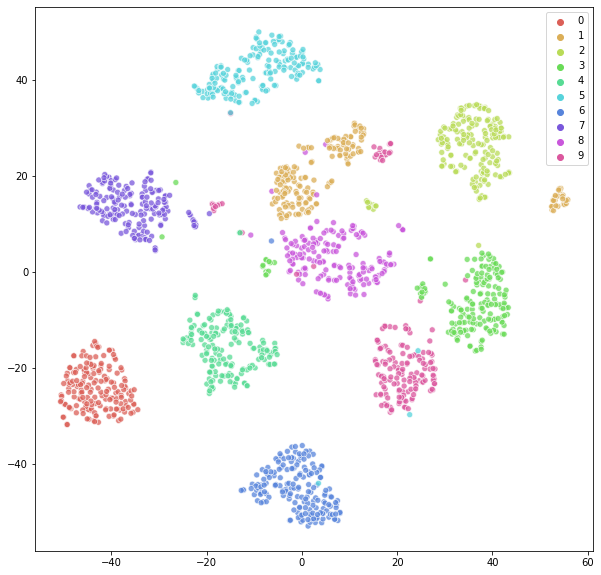

In [17]:
# Run TSNE again to check that the implementation's output matches the library version's output!
X_tsne = tsne(X)

plt.figure(figsize=(10,10))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.75
)
plt.show()

If your implementation is correct, you should see good separation much like the run in Question 1, though the shapes and locations of the clusters likely won't be the same (due to our implementation and parameters differing slightly from the sklearn t-SNE).

## 3. Conceptual Questions

### 3.a) To optimize the performance of the method, we scaled P by 4 for the first 100 iterations of gradient descent. How does this improve performance?

TODO:  The algorithm assumes that the cost function was greater than it actually was for the first 100 iterations. This accelerated the learning process until we were in a closer order of magnitude to what we desired.

### 3.b) In the above implementation, we used PCA to first reduce the input to 50 dimensions/features - why is it preferred to run t-SNE on data that doesn't have a high number of dimensions?

TODO: The goal of t-SNE is to take your high dimensional data and represent it correctly in lower dimensions. Points that are close in high dimensions remain close in the low dimensional representation. While t-SNE is a dimensionality reduction technique, it is used for **visualization and not data pre-processing**. For this reason, data's dimensionality is commonly reduced to 2 with t-SNE, so that you can then plot the data in two dimensions. If there were a high number of dimensions, it is becomes difficult to visualize. Additionally, t-SNE is optimal for perplexity values between 5-50.

### 3.c) t-SNE is known to be a 'nonlinear' dimensionality reduction method. As such the distance between points does not accurately reflect distance in the original space. Based on the math behind the technique, explain why t-SNE is nonlinear.

TODO: For each data point (x<sub>i</sub>) t-SNE centers a Gaussian distribution over that point. Then it measures the density of all points (x<sub>j</sub>) under that Gaussian distribution. This implies that the distance between two points are nonlinear, since the section of nearby neighbors is biased. t-SNE selects the nearest neighbor for a data point (x<sub>i</sub>) within 3 standard deviations approximately 99.7% of the time.

### 3.d) Explain the improvement of this method over SNE - specifically, why is the distance between two points in the lower-dimensional space defined as (1) rather than the definition of distance used for the higher dimensional space (2), ignoring the symmetrization?


$$q_{i j} = \frac{(1+||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1+||y_k - y_l||^2)^{-1}} \;\;\;\;\;\;  (1)$$

$$p_{i j} = \frac{\text{exp}(-||x_i - x_j||^2 / 2\sigma^2)}{\sum_{k \neq l}\text{exp}(-||x_k - x_l||^2/ 2\sigma^2)} \;\;\;\;\;\;  (2)$$


TODO: SNE constructs reasonably good visualizations. But an issue it has is that it is hindered by a cost function that is difficult to optimize. Resulting in a "crowding issue". Using **(2)** causes problems when a high-dimensional datapoint x<sub>i</sub> is an outlier (i.e., all pairwise distances -||x_i - x_j||<sup>2</sup> are large for x<sub>i</sub>). The values of p<sub>ij</sub> for the outlier are too small for all possible j's, so the location of its low-dimensional map point y<sub>i</sub> has very little effect on the cost function. As a result, the position of the map point is not well determined by the positions of the other map
points

In the low-dimensional map, a probability distribution that has much heavier tails are used to convert distances into probabilities. Allowing significant distances in the high-dimensional space to be faithfully modeled. We use **(1)**, because (||1 + y<sub>i</sub> − y<sub>j</sub>||<sup>2</sup>)<sup>-1</sup> approaches an inverse square law for large pairwise distances y<sub>i</sub> − y<sub>j</sub> in the low-dimensional space. This makes the map’s representation of joint probabilities nearly invariant to changes in the map's scale for points that are far away from one another. Therefore, large clusters of points that are far apart interact in just the same way as individual points.